### Dependencies

In [ ]:
import time
import os
import pandas as pd
import requests
from tqdm import tqdm
import timeit
import random
import datetime as dt
import pandas_datareader.data as pdr
from pathlib import Path

In [ ]:
%pip install pyportfolioopt
%pip install yfinance
%pip install statsmodels --upgrade

     |████████████████████████████████| 61 kB 801 kB/s 
     |████████████████████████████████| 2.8 MB 10.4 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31
     |████████████████████████████████| 6.4 MB 8.0 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1,

     |████████████████████████████████| 9.8 MB 4.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
#Mount your Drive
#Right click CSE543 Shared Folder, and Save a Shortcut to "My Drive"

import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import sys
CSE543 = '/content/drive/MyDrive/CSE543'
if CSE543 in sys.path:
    pass
else:
    sys.path.insert(0, CSE543)

from utils import key, makeurl, makeurlMA, makeurlHT, makeFactorName
from utils import MAfactor, getDate, Symmetric_Orthogonalize


# Get Monthly Return Values for Stocks
- last date of next month - last date of current month (e.g. 2.28 - 1.31)


In [ ]:
sp500cons = pd.read_csv("https://raw.githubusercontent.com/ljh-sufe/cse543final/main/spxstocks.csv")
sp500cons = sp500cons.set_index("Date")
stock_list = sp500cons.Ticker.value_counts().index.to_list()    # sp500 constituent stocks

# For testing
random.seed(100)
# stock_list = random.sample(stock_list, 20) # for test
# stock_list = stock_list[1:5] # for test

In [ ]:
len(stock_list)

775

In [ ]:
# Function to compute monthly return for given stock
def get_monthly_return(code,key):
  url = f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={code}&apikey={key}"
  sr = pd.Series()
  r = requests.get(url)
  data = r.json()
  if 'Error Message' in data:
    return sr
  sr = pd.Series(data=[d['4. close']for d in data["Monthly Time Series"].values()],index=data["Monthly Time Series"].keys())
  sr = sr.reindex(index=sr.index[::-1])
  
  # Compute monthly return
  prev_close = 0
  d = {'date':[], 'return':[]}
  for date,price in sr.items():
    price,date = float(price), str(date)
    if prev_close:
      d['date'].append(dt.datetime.strptime(date[:-2]+"01", "%Y-%m-%d"))
      # d['return'].append(price - prev_close)
      d['return'].append(price / prev_close - 1)
    prev_close = price
  result = pd.Series(data=d['return'],index=d['date'])
  result = result.reindex(index = pd.date_range("2000-01-01", "2022-03-31", freq="MS"))
  result = result.fillna(value=0)
  result.name = "Monthly Return ($)"
  return result

In [ ]:
# Get monthly return and save
monthly_return_path = "/content/drive/MyDrive/CSE543/monthly_returns"

if not os.path.exists(monthly_return_path):
  os.makedirs(monthly_return_path)
file_set = set(os.listdir(monthly_return_path))

total_stocks = len(stock_list)
failed_stocks = 0

for stock in stock_list:
  file_name = os.path.join(monthly_return_path,f"{stock}.csv")
  if os.path.basename(file_name) in file_set:
     continue
  try:
    result = get_monthly_return(stock, key)
    if result.empty:
      continue
    result.to_csv(file_name)
  except:
    #print("Failed to get monthly returns for:" +stock) #Takes awhile to print out, replaced with variable
    failed_stocks+=1
    stock_list.remove(stock) #Remove for further analysis

print("Failed to get return data for: "+ str(failed_stocks) +" out of " +str(total_stocks)+" stocks")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


Failed to get return data for: 0 out of 775 stocks


# Factors

In [ ]:
# Define date range
date_range = pd.date_range("2000-01-01", "2022-03-31", freq="BM")    # all date list 
dateList = [str(d.date()) for d in date_range]

# Define factor class and set intervals

factorsList = []
factors = ["SMA", "MOM", "ROC", "ROCR", "MFI"]    # factors we used
intervals = [20, 60, 200]     # 20 60 200 days moving average,...
for f in factors:
  for i in intervals:
    factorsList.append(MAfactor(f, i))

In [ ]:
main_path = "/content/drive/MyDrive/CSE543/data"

In [ ]:
# Junhao    # calculate monthly return

monthlyReturn = None
dates = pd.date_range("2000-01-01", "2022-03-31", freq="MS")
for stock in tqdm(stock_list):
  try:

    temp = pd.read_csv("/content/drive/MyDrive/CSE543/monthly_returns/"+stock+".csv")
    temp["stock"] = stock
    temp = temp.set_index(["Unnamed: 0", "stock"])

  except:
    
    temp = pd.DataFrame(index=pd.MultiIndex.from_arrays( [dates, [stock for i in dates] ]))
  
  if monthlyReturn is None:
    monthlyReturn = temp
  else:
    monthlyReturn = monthlyReturn.append(temp)
monthlyReturn.index.names = ["date", "stock"]
monthlyReturn = monthlyReturn.reset_index().sort_values(by=["date", "stock"]).set_index(["date", "stock"])


100%|██████████| 775/775 [00:35<00:00, 21.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})


In [ ]:
def getFactor(url, factor, dateList):
    factorName = makeFactorName(keyword=factor.name, interval="daily", time_period=factor.timeperiod)
    failed_to_fetch = False  
    r = requests.get(url)
    data = r.json()
    if data and f"Technical Analysis: {factor.name}" in data and len(data[f"Technical Analysis: {factor.name}"]):
        df = pd.DataFrame(data[f"Technical Analysis: {factor.name}"]).T[factor.name]
        df = df.reindex(dateList)
        df = df.fillna(value=0)
        df.name = factorName
        return failed_to_fetch , pd.DataFrame(df)
    else:
        failed_to_fetch = True
        return failed_to_fetch , pd.DataFrame(index=dateList)

In [ ]:
sr = pd.read_csv('/content/drive/MyDrive/CSE543/stock_list.csv')     # sp500 constituents
stock_list = sr['0'].tolist()
print(f"Total stock number for analysis: {len(stock_list)}")

Total stock number for analysis: 734


In [ ]:
b = None
for factor in factorsList:

    filepath = os.path.join(main_path,f"{factor.name}_{factor.timeperiod}")
    try:
        a = pd.read_csv(filepath  + ".csv").set_index(["Unnamed: 0", "stock"])    # get data from local path
    except:
        print(1)
        a = None
        filepath = os.path.join(main_path,f"{factor.name}_{factor.timeperiod}")    
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        file_set = set(os.listdir(filepath))

        for file in file_set:
            csv_file_path = os.path.join(filepath, f"{file}")
            d = pd.read_csv(csv_file_path).set_index("Unnamed: 0")
            d["stock"] = file.split("_", 2)[0]
            d = d.reset_index().set_index(["Unnamed: 0", "stock"])
            if a is None:
                a = d
            else:
                a = a.append(d)
        a.to_csv(filepath  + ".csv")

    a = a.sort_index(level=0).groupby("Unnamed: 0").apply(lambda x: (x-x.mean())/x.std())
    a.index.names = ['date', 'stock']

    if b is None:
        b = a
    else:
        b = b.join(a)
    print(a.shape)


(198648, 1)
(198648, 1)
(198648, 1)
(198648, 1)
(198648, 1)
(198648, 1)
(196245, 1)
(196245, 1)
(196245, 1)
(196245, 1)
(196245, 1)
(195978, 1)
(195978, 1)
(195978, 1)
(195978, 1)


In [ ]:

returnDF = None
for count, date in enumerate(dates):
    
    dateBM = dateList[count]
    return_ = monthlyReturn.loc[date].reindex(b.loc[dateBM].index)
    if returnDF is None:
        returnDF = return_
    else:
        returnDF = returnDF.append(return_)
b["return"] = returnDF.values

In [ ]:
# Junhao
# get data from api

b = None
failed_stock = set()
for stock in tqdm(stock_list):    
    a = None
    for factor in factorsList:
        filepath = os.path.join(main_path,f"{factor.name}_{factor.timeperiod}")
        if not os.path.exists(filepath):    # create folder for factors
            os.makedirs(filepath)
        file_set = set(os.listdir(filepath))
        csv_file_path = os.path.join(filepath, f"{stock}_{factor.name}_daily_{factor.timeperiod}.csv")
        try:
          d = pd.read_csv(csv_file_path).set_index("Unnamed: 0")
        except:
          url = makeurlMA(keyword=factor.name, stock=stock, interval="daily", time_period=factor.timeperiod)
          failed_to_fetch, d = getFactor(url, factor, dateList)
          if failed_to_fetch:
            failed_stock.add(stock)
            continue
          # Save to csv file
          d.to_csv(csv_file_path)
          print(f"File saved to {csv_file_path}")

        if a is None:
            a = d
        else:
            a = a.join(d)
    a["stock"] = stock
    a["return"] = monthlyReturn.query(f"stock == '{stock}'").shift(-1).values
    
    if b is None:
        b = a
    else:
        b = b.append(a)

b.index.name = "time"
b = b.reset_index().sort_values(by=["time", "stock"]).set_index(["time", "stock"])
c = b.corr()
# print(c.values)


In [ ]:
b#the column 'return' is the return of next month, so when do the regression, just do it directly. there is no need to use shiftted ones

SMA_daily_20  SMA_daily_60  SMA_daily_200  MOM_daily_20  \
date       stock                                                            
2000-01-31 A          0.318913     -0.256272            NaN     -0.335199   
           AA        -0.244464     -0.256272            NaN     -0.007286   
           AAL       -0.244464     -0.256272            NaN     -0.007286   
           AAP       -0.244464     -0.256272            NaN     -0.007286   
           AAPL      -0.234442     -0.245558            NaN     -0.006963   
...                        ...           ...            ...           ...   
2022-03-31 YUM       -0.089572     -0.080011      -0.084135     -0.189915   
           ZBH       -0.077978     -0.087392      -0.056365      0.061943   
           ZBRA       0.861381      0.970761       1.154073      0.076241   
           ZION      -0.256142     -0.250972      -0.278419     -0.234509   
           ZTS        0.145443      0.152899       0.161041     -0.404013   

                  MOM_daily_60  MOM_daily_200  ROC_daily_20  ROC_daily_60  \
date       stock                                                            
2000-01-31 A         -0.081072            NaN     -0.995839     -0.126514   
           AA        -0.081072            NaN      0.206891     -0.126514   
           AAL       -0.081072            NaN      0.206891     -0.126514   
           AAP       -0.081072            NaN      0.206891     -0.126514   
           AAPL      -0.075759            NaN      0.283343      0.765791   
...                        ...            ...           ...           ...   
2022-03-31 YUM       -0.104844      -0.087715     -0.255188     -0.644715   
           ZBH        0.219776      -0.607742      0.117419      0.186793   
           ZBRA      -2.685261      -1.961486     -0.094122     -1.586469   
           ZION       0.192074       0.101153     -0.420016      0.103326   
           ZTS       -0.403031      -0.021029     -0.428135     -0.808560   

                  ROC_daily_200  ROCR_daily_20  ROCR_daily_60  ROCR_daily_200  \
date       stock                                                                
2000-01-31 A                NaN       0.447875      -1.209596             NaN   
           AA               NaN      -1.381876      -1.209596             NaN   
           AAL              NaN      -1.381876      -1.209596             NaN   
           AAP              NaN      -1.381876      -1.209596             NaN   
           AAPL             NaN       0.774631       0.969940             NaN   
...                         ...            ...            ...             ...   
2022-03-31 YUM        -0.123548       0.250086       0.066666        0.240903   
           ZBH        -0.823104       0.400992       0.448750       -0.158431   
           ZBRA       -0.913827       0.315308      -0.365692       -0.210016   
           ZION        0.648442       0.183329       0.410383        0.681188   
           ZTS        -0.073081       0.180004      -0.008481        0.269637   

                  MFI_daily_20  MFI_daily_60  MFI_daily_200    return  
date       stock                                                       
2000-01-31 A         -0.032766     -1.346930            NaN -0.143837  
           AA        -1.264758     -1.346930            NaN  0.000000  
           AAL       -1.264758     -1.346930            NaN  0.000000  
           AAP       -1.264758     -1.346930            NaN  0.000000  
           AAPL       0.903082      1.049319            NaN  0.009143  
...                        ...           ...            ...       ...  
2022-03-31 YUM        0.080210     -0.023102       0.324752 -0.033040  
           ZBH        0.202300      0.507903       0.209940  0.005582  
           ZBRA       0.655713     -0.042590       0.261714  0.000871  
           ZION      -0.228284      0.668626       0.600541 -0.075187  
           ZTS       -0.388902     -0.362319       0.152843 -0.026130  

[198915 rows x 16 colum

Covariance matrix estimation with various methods on toy stock price data set.

In [ ]:
from pypfopt import risk_models as rm
import pandas as pd 
import numpy as np 
import yfinance as yf

#defining some tickers
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA"]

#importing ticker's stock data
data = yf.download(tickers, period="max")
prices = data["Adj Close"].dropna(how="all")

#calculating returns
daily_return = prices.diff(1)

#computing different covariance matrix 
s_cov = rm.sample_cov(daily_return, returns_data = True)
lw_cov = rm.risk_matrix(daily_return, returns_data = True, method = 'ledoit_wolf')
exp_cov = rm.risk_matrix(daily_return, returns_data = True, method = 'exp_cov')
semi_cov = rm.risk_matrix(daily_return, returns_data = True, method = 'semicovariance')
approx_cov = rm.risk_matrix(daily_return, returns_data = True, method = 'oracle_approximating')

from pypfopt import plotting
# plotting.plot_covariance(s_cov, plot_correlation=True);
# plotting.plot_covariance(lw_cov, plot_correlation=True);

Eigenvalue Decomposition to reduce the computational complexity of computing the covariance matrix. Uses eigendecomposition.

In [ ]:
import pandas as pd
import numpy as np


#Implements eigen decomp on covariance matrix
#Returns eigen decomp to be combined with target
def eig_decomp(cov_mat, num_components): 

    #Computing eigenvalues/eigenvectors
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Sorting in descending order, this helps arrange the principal component in descending order of variability
    #First component = pricinipal component that captures the highest variability
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]

    #Choose K greatest eigenvalues
    #Selects subset from num_components
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]

    eigenvalue_subset = np.diag(sorted_eigenvalue[0:num_components])

    decomp_cov_1 = np.dot(eigenvector_subset , eigenvalue_subset)
     
    decomp_cov_2 = np.dot(decomp_cov_1, eigenvector_subset.transpose()) 

    #Altered and reduced covariance matrix
    # return decomp_cov_2
    return decomp_cov_2 + np.diag(sorted_eigenvalue)


Testing Linear Regression and other models for the expected return regression.  Trying to optimize time period for forecasting expected monthly return. 

In [ ]:
from functools import lru_cache
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

#getting data 
b_new = b.fillna(0)
X = b_new.iloc[:,:-1].to_numpy()
Y = b_new.iloc[:,-1].to_numpy().reshape(-1,1)
X_tot = X
Y_tot = Y
 
# mod 733 for 1 year 
# mod 2199 for 3 year
# mod 3665 for 5 years
# mod 7330 for 10 years 

X = X_tot[0:733]
Y = Y_tot[0:733]


#defining regression and fitting
LR = LinearRegression()
krr = KernelRidge(alpha=1)
krr.fit(X, Y)
LR.fit(X, Y)

# #predicting 
for i in range(0, int(len(b)/734)):
  y_hat_LR = LR.predict(X_tot[i*733].reshape(-1,1).T)
  y_hat_KR = krr.predict(X_tot[i*733].reshape(-1,1).T)

  print('YHat LR:',y_hat_LR)
  print('YHat KR:',y_hat_KR)
  print('Y:',Y_tot[i*733])

YHat LR: [[-0.18872467]]
YHat KR: [[-0.16104843]]
Y: [-0.1438365]
YHat LR: [[0.05855184]]
YHat KR: [[0.07178068]]
Y: [0.00615791]
YHat LR: [[-0.04049142]]
YHat KR: [[-0.0260317]]
Y: [-0.07594937]
YHat LR: [[0.57449971]]
YHat KR: [[0.59451196]]
Y: [0.65288889]
YHat LR: [[0.01764467]]
YHat KR: [[0.03179228]]
Y: [0.02985075]
YHat LR: [[0.38651507]]
YHat KR: [[0.40486191]]
Y: [0.28705882]
YHat LR: [[-0.01202449]]
YHat KR: [[0.00561479]]
Y: [0.]
YHat LR: [[-0.06719576]]
YHat KR: [[-0.04905263]]
Y: [0.]
YHat LR: [[-0.01278143]]
YHat KR: [[-0.00132916]]
Y: [0.08580593]
YHat LR: [[-0.05572538]]
YHat KR: [[-0.0448431]]
Y: [-0.04173176]
YHat LR: [[0.02517147]]
YHat KR: [[0.04535164]]
Y: [0.07843137]
YHat LR: [[0.14389187]]
YHat KR: [[0.1528744]]
Y: [0.01486698]
YHat LR: [[-0.01476636]]
YHat KR: [[-0.00997094]]
Y: [-0.04118202]
YHat LR: [[-0.01428134]]
YHat KR: [[0.]]
Y: [0.]
YHat LR: [[-0.01428134]]
YHat KR: [[0.]]
Y: [0.]
YHat LR: [[-0.00494058]]
YHat KR: [[0.01580113]]
Y: [0.]
YHat LR: [[0.161

Testing out Vectorized Autoregressive Models as a new way to forecast expected return.  Just further evaluating the rough preformance of various models for this regression task. 

In [ ]:
import numpy as np
from statsmodels.tsa.api import VAR

def vector_AR(train_data, test_data):
  model = VAR(train_data)
  aic = []
  for i in range(0, 100):
    result = model.fit(i)
    aic.append(result.aic)

  model_fitted = model.fit(np.argmin(aic))
  lag_order = model_fitted.k_ar

  forecast_input = test_data.values[-lag_order:]
  fc = model_fitted.forecast(y=forecast_input, steps=nobs)
  df_forecast = pd.DataFrame(fc)

  return df_forecast

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

#getting training and testing data
nobs = len(df)-100
train_data = b.iloc[:nobs,1:]
test_data = b.iloc[nobs:,1:]

#checking for stationarity
for name, column in train_data.iteritems(): 
  if name != 'Date':
    print(adfuller(column, autolag='AIC')[1])

#constructing model with optimized hyperparameters
forecasted = vectore_AR(train_data, test_data)
forecasted

Comparing the peformance of LR, RF, SVR, and NN machine learning models for forecasting the monthly expected return. Using negative mean squared error as the preformance metric. 

LR: -0.196717 (0.470882)
NN: -1.785245 (2.264194)
KNN: -0.212315 (0.462937)
RF: -0.239078 (0.456551)
SVR: -0.183301 (0.483973)


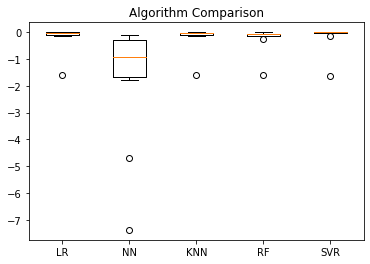

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR' , SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X, Y, cv=tscv, scoring='neg_mean_squared_error')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

### Fill NA Values. Propogate last valid observation foreward to next valid backfill.

In [ ]:
b = b.fillna(method="backfill")

b.iloc[:, :-1] = b.iloc[:, :-1].groupby("date").apply(Symmetric_Orthogonalize)

corrList = []

# %pip install eventlet

/content/drive/MyDrive/CSE543/utils.py:62: RuntimeWarning: invalid value encountered in power
  D = D ** (-0.5)
/content/drive/MyDrive/CSE543/utils.py:62: RuntimeWarning: divide by zero encountered in power
  D = D ** (-0.5)


2000-04-28
2000-05-31
2000-07-31
2002-03-29
2004-05-31
2021-05-31


In [ ]:
np.real(b)

array([[ 0.20740669, -0.17608984, -0.00511564, ..., -0.12209389,
        -0.02909858, -0.1438365 ],
       [-0.00263803, -0.00270958, -0.00516206, ..., -0.02344445,
        -0.0293627 ,  0.        ],
       [-0.00263803, -0.00270958, -0.00516206, ..., -0.02344445,
        -0.0293627 ,  0.        ],
       ...,
       [ 0.00067798, -0.02373643,  0.02165988, ...,  0.00420187,
         0.00946183,  0.00087095],
       [-0.00750888,  0.00074915, -0.01312739, ...,  0.04827122,
         0.02049212, -0.07518691],
       [ 0.00241792, -0.00274799,  0.00411123, ..., -0.03869434,
         0.00141326, -0.02612962]])

In [ ]:
# Junhao 
# portfolio optimization 
# overall framework

from pypfopt import risk_models as rm
import yfinance as yf
import numpy as np
from cvxpy import Variable, Parameter, Maximize, Problem, sum_squares, norm, quad_form, abs, vstack
import cvxpy as cp
from sklearn.linear_model import LinearRegression



riskAverse = 70

#defining some tickers
tickers = list(set(b.index.get_level_values(1).to_list()))

#importing ticker's stock data
# data = yf.download(tickers, period="max")
data = pd.read_csv("/content/drive/MyDrive/CSE543/daily_price_.csv")
# prices = data["Adj Close"].dropna(how="all")
prices = data.set_index("Date").dropna(how="all")
prices = prices.T.reindex(tickers).T
dailyReturn = prices / prices.shift(-1) -1


timeInterval = 8          # years
riskTimeInterval = 120    # days
date_range = pd.date_range("2014-01-01", "2022-03-31", freq="BM")
dateList = [str(d.date()) for d in date_range]

portfolio = None    # initial portfolio
wval = None
for date in tqdm(dateList):
  
  trainStartDate = getDate(date, timeInterval*365)   # 8 years ago
  trainEndDate = getDate(date, 1)                    # last month
  trainData = b.loc[trainStartDate : trainEndDate]
  trainX = trainData.iloc[:, :-1]
  
  trainy = trainData["return"]

  trainy = trainy.rank()
  trainy = (trainy - trainy.mean()) / trainy.std()

  riskStartDate = getDate(date, riskTimeInterval)    # 120 days ago
  riskEndDate = getDate(date, 1)                     # yesterday
  riskDailyReturn = dailyReturn.loc[riskStartDate: riskEndDate]

  testX = b.loc[date].iloc[:, :-1]
  testX = testX.loc[riskDailyReturn.columns.to_list()]
  testX = testX[~testX.index.duplicated(keep='first')]

  testy = b.loc[date]["return"]
  testy = testy.loc[riskDailyReturn.columns.to_list()]
  testy = testy[~testy.index.duplicated(keep='first')]
  #%% Tillman can try some more awesome methods here! return y_hat!
  LR = LinearRegression()
  LR.fit(np.real(trainX), trainy)
  y_hat = LR.predict(np.real(testX))
  corrList.append(np.corrcoef(y_hat, testy)[0,1])
  #%%
  

  #%% Tillman and Shane can try some more awesome methods here! return cov matrix!
  lw_cov = rm.risk_matrix(riskDailyReturn, returns_data = True, method = 'ledoit_wolf')    # cov estimation
  cov = eig_decomp(lw_cov, 10 )       # eigen values decomposition and cov matrix sparsification
  #%%

  numberOfStocks = cov.shape[0]


  # optimization
  w = Variable(numberOfStocks)
  portfolioExpectedReturn = y_hat @ w    # expect return
  portfolioRisk = quad_form(w, cov) * 240    # portfolio risk

  objectFunction = portfolioExpectedReturn - riskAverse * portfolioRisk    # objective function
  cons = []     # constraints
  # cons.append(cp.sum(w) <= 1 + 1e-6)
  # cons.append(cp.sum(w) >= 1 - 1e-6)    # sum of weights equal to 1
  cons.append(w <= 1)
  cons.append(w >= -1)

  prob = Problem(Maximize(objectFunction), constraints=cons)
  # argskw = {'max_iters': 5000, 'feastol': 1e-5, 'abstol': 1e-5}
  # prob.solve(solver='ECOS')
  try:

    prob.solve()
  
    if prob.status in ('optimal', 'optimal_inaccurate'):
        wval = np.array(w.value)  
    else:
        print("date="+date + '  optimize failed')
        wval = wval
        pass
  except:
    print("date="+date + '  optimize failed')
    if wval is None:
        wval = np.ones(numberOfStocks) / numberOfStocks
    else:
        wval = wval
  # end optimization



  actualPortfolioReturn = wval.dot(testy)
  if portfolio is None:
    portfolio = pd.DataFrame([actualPortfolioReturn])
  else:
    portfolio = portfolio.append([actualPortfolioReturn])



  1%|          | 1/99 [00:17<28:51, 17.67s/it]

date=2014-01-31  optimize failed


  2%|▏         | 2/99 [00:50<43:16, 26.77s/it]

date=2014-02-28  optimize failed


  7%|▋         | 7/99 [02:01<33:08, 21.62s/it]

date=2014-07-31  optimize failed


 18%|█▊        | 18/99 [03:09<22:18, 16.52s/it]

date=2015-06-30  optimize failed


 19%|█▉        | 19/99 [03:59<35:26, 26.59s/it]

date=2015-07-31  optimize failed


 20%|██        | 20/99 [04:49<44:15, 33.62s/it]

date=2015-08-31  optimize failed


 32%|███▏      | 32/99 [05:51<16:51, 15.09s/it]

date=2016-08-31  optimize failed


 37%|███▋      | 37/99 [06:17<09:20,  9.03s/it]

date=2017-01-31  optimize failed


 42%|████▏     | 42/99 [07:06<14:35, 15.35s/it]

date=2017-06-30  optimize failed


 43%|████▎     | 43/99 [07:39<19:17, 20.67s/it]

date=2017-07-31  optimize failed


 46%|████▋     | 46/99 [07:57<10:55, 12.36s/it]

date=2017-10-31  optimize failed


 49%|████▉     | 49/99 [08:32<11:59, 14.39s/it]

date=2018-01-31  optimize failed


 55%|█████▍    | 54/99 [08:51<05:51,  7.80s/it]

date=2018-06-29  optimize failed


 62%|██████▏   | 61/99 [09:12<03:51,  6.10s/it]

date=2019-01-31  optimize failed


 63%|██████▎   | 62/99 [09:45<08:44, 14.18s/it]

date=2019-02-28  optimize failed


 70%|██████▉   | 69/99 [10:41<06:57, 13.93s/it]

date=2019-09-30  optimize failed


 74%|███████▎  | 73/99 [11:36<07:02, 16.24s/it]

date=2020-01-31  optimize failed


 76%|███████▌  | 75/99 [12:14<07:37, 19.07s/it]

date=2020-03-31  optimize failed


 88%|████████▊ | 87/99 [12:52<01:34,  7.90s/it]

date=2021-03-31  optimize failed


100%|██████████| 99/99 [13:42<00:00,  8.31s/it]

date=2022-03-31  optimize failed


In [ ]:
portfolio = portfolio+1


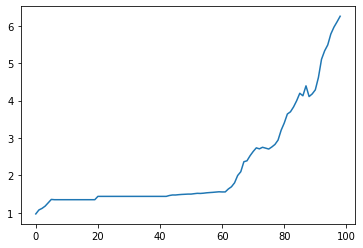

0.18732171819441537

In [ ]:

from matplotlib import pyplot as plt
plt.figure()
plt.plot(portfolio.cumprod().values)
plt.show()
np.nanmean(corrList[:-2])

## Testing different convariance matrix algorithms

In [ ]:
# Shane

from pypfopt import risk_models as rm
import yfinance as yf
import numpy as np
from cvxpy import Variable, Parameter, Maximize, Problem, sum_squares, norm, quad_form, abs, vstack
import cvxpy as cp
from sklearn.linear_model import LinearRegression

#cov_matrix_methods = ["sample_cov",
#        "semicovariance",
#        "exp_cov",
#        "ledoit_wolf",
#        "ledoit_wolf_constant_variance",
#        "ledoit_wolf_single_factor",
#        "ledoit_wolf_constant_correlation",
#        "oracle_approximating" ]

#sample_cov, exp_cov, ledoit_wolf_constant_correlation don't work

#semicovariance, ledoit_wolf_single_factor give wonky results, leaving out for now

cov_matrix_methods = [
        "ledoit_wolf",
        "ledoit_wolf_constant_variance",
        "oracle_approximating" ]

figs = []

np_nanmeans = []

portfolios = [] #for evaluations

for method in cov_matrix_methods:

  try:

    riskAverse = 70

    #defining some tickers
    tickers = list(set(b.index.get_level_values(1).to_list()))

    #importing ticker's stock data
    # data = yf.download(tickers, period="max")
    data = pd.read_csv("/content/drive/MyDrive/CSE543/daily_price_.csv")
    # prices = data["Adj Close"].dropna(how="all")
    prices = data.set_index("Date").dropna(how="all")
    prices = prices.T.reindex(tickers).T
    dailyReturn = prices / prices.shift(-1) -1


    timeInterval = 8          # years
    riskTimeInterval = 120    # days
    date_range = pd.date_range("2014-01-01", "2022-03-31", freq="BM")
    dateList = [str(d.date()) for d in date_range]

    portfolio = None    # initial portfolio
    wval = None
    for date in tqdm(dateList):
      
      trainStartDate = getDate(date, timeInterval*365)   # 8 years ago
      trainEndDate = getDate(date, 1)                    # last month
      trainData = b.loc[trainStartDate : trainEndDate]
      trainX = trainData.iloc[:, :-1]
      
      trainy = trainData["return"]

      trainy = trainy.rank()
      trainy = (trainy - trainy.mean()) / trainy.std()

      riskStartDate = getDate(date, riskTimeInterval)    # 120 days ago
      riskEndDate = getDate(date, 1)                     # yesterday
      riskDailyReturn = dailyReturn.loc[riskStartDate: riskEndDate]

      testX = b.loc[date].iloc[:, :-1]
      testX = testX.loc[riskDailyReturn.columns.to_list()]
      testX = testX[~testX.index.duplicated(keep='first')]

      testy = b.loc[date]["return"]
      testy = testy.loc[riskDailyReturn.columns.to_list()]
      testy = testy[~testy.index.duplicated(keep='first')]
      #%% Tillman can try some more awesome methods here! return y_hat!
      LR = LinearRegression()
      LR.fit(np.real(trainX), trainy)
      y_hat = LR.predict(np.real(testX))
      corrList.append(np.corrcoef(y_hat, testy)[0,1])
      #%%
      

      #%% Tillman and Shane can try some more awesome methods here! return cov matrix!
      lw_cov = rm.risk_matrix(riskDailyReturn, returns_data = True, method = method)
      cov = eig_decomp(lw_cov, 10 )
      #%%

      numberOfStocks = cov.shape[0]


      # optimization
      w = Variable(numberOfStocks)
      portfolioExpectedReturn = y_hat @ w
      portfolioRisk = quad_form(w, cov) * 240

      objectFunction = portfolioExpectedReturn - riskAverse * portfolioRisk
      cons = []
      # cons.append(cp.sum(w) <= 1 + 1e-6)
      # cons.append(cp.sum(w) >= 1 - 1e-6)    # sum of weights equal to 1
      cons.append(w <= 1)
      cons.append(w >= -1)

      prob = Problem(Maximize(objectFunction), constraints=cons)
      # argskw = {'max_iters': 5000, 'feastol': 1e-5, 'abstol': 1e-5}
      # prob.solve(solver='ECOS')
      try:

        prob.solve()
      
        if prob.status in ('optimal', 'optimal_inaccurate'):
            wval = np.array(w.value)  
        else:
            print("date="+date + '  optimize failed')
            wval = wval
            pass
      except:
        print("date="+date + '  optimize failed')
        if wval is None:
            wval = np.ones(numberOfStocks) / numberOfStocks
        else:
            wval = wval
      # end optimization



      actualPortfolioReturn = wval.dot(testy)
      if portfolio is None:
        portfolio = pd.DataFrame([actualPortfolioReturn])
      else:
        portfolio = portfolio.append([actualPortfolioReturn])

    portfolio = portfolio+1

    portfolios.append(portfolio)
    #plt.clf()
    #fig = plt.figure()
    #plt.plot(portfolio.cumprod().values)
    figs.append(portfolio.cumprod().values)
    #plt.clf()
    np_nanmeans.append(np.nanmean(corrList[:-2]))
  except:
    print("Failed for method: " +method)

  7%|▋         | 7/99 [00:51<19:52, 12.96s/it]

date=2014-07-31  optimize failed


 16%|█▌        | 16/99 [01:28<12:28,  9.02s/it]

date=2015-04-30  optimize failed


 18%|█▊        | 18/99 [02:20<26:47, 19.84s/it]

date=2015-06-30  optimize failed


 19%|█▉        | 19/99 [03:11<38:52, 29.15s/it]

date=2015-07-31  optimize failed


 20%|██        | 20/99 [04:02<46:56, 35.65s/it]

date=2015-08-31  optimize failed


 30%|███       | 30/99 [04:38<10:46,  9.37s/it]

date=2016-06-30  optimize failed


 32%|███▏      | 32/99 [05:24<20:15, 18.14s/it]

date=2016-08-31  optimize failed


 42%|████▏     | 42/99 [06:23<13:59, 14.73s/it]

date=2017-06-30  optimize failed


 43%|████▎     | 43/99 [06:57<19:00, 20.36s/it]

date=2017-07-31  optimize failed


 46%|████▋     | 46/99 [07:32<15:18, 17.34s/it]

date=2017-10-31  optimize failed


 52%|█████▏    | 51/99 [07:53<06:57,  8.69s/it]

date=2018-03-30  optimize failed


 55%|█████▍    | 54/99 [08:27<09:55, 13.24s/it]

date=2018-06-29  optimize failed


 59%|█████▊    | 58/99 [08:58<08:16, 12.11s/it]

date=2018-10-31  optimize failed


 65%|██████▍   | 64/99 [09:38<07:17, 12.51s/it]

date=2019-04-30  optimize failed


 71%|███████   | 70/99 [10:29<07:06, 14.70s/it]

date=2019-10-31  optimize failed


 72%|███████▏  | 71/99 [11:03<09:29, 20.34s/it]

date=2019-11-29  optimize failed


 74%|███████▎  | 73/99 [11:37<08:44, 20.16s/it]

date=2020-01-31  optimize failed


 88%|████████▊ | 87/99 [12:41<02:15, 11.30s/it]

date=2021-03-31  optimize failed


  2%|▏         | 2/99 [00:27<24:47, 15.33s/it]

date=2014-02-28  optimize failed


  6%|▌         | 6/99 [00:48<13:16,  8.57s/it]

date=2014-06-30  optimize failed


  7%|▋         | 7/99 [01:39<34:15, 22.34s/it]

date=2014-07-31  optimize failed


 10%|█         | 10/99 [02:05<22:20, 15.06s/it]

date=2014-10-31  optimize failed


 18%|█▊        | 18/99 [03:08<23:07, 17.13s/it]

date=2015-06-30  optimize failed


 19%|█▉        | 19/99 [03:59<36:12, 27.15s/it]

date=2015-07-31  optimize failed


 20%|██        | 20/99 [04:49<45:02, 34.21s/it]

date=2015-08-31  optimize failed


 32%|███▏      | 32/99 [05:50<16:33, 14.83s/it]

date=2016-08-31  optimize failed


 42%|████▏     | 42/99 [06:53<14:06, 14.86s/it]

date=2017-06-30  optimize failed


 43%|████▎     | 43/99 [07:10<14:24, 15.44s/it]

date=2017-07-31  optimize failed


 45%|████▌     | 45/99 [07:28<11:30, 12.79s/it]

date=2017-09-29  optimize failed


 46%|████▋     | 46/99 [08:01<16:47, 19.02s/it]

date=2017-10-31  optimize failed


 49%|████▉     | 49/99 [08:36<13:59, 16.79s/it]

date=2018-01-31  optimize failed


 56%|█████▌    | 55/99 [08:57<05:30,  7.50s/it]

date=2018-07-31  optimize failed


 58%|█████▊    | 57/99 [09:14<06:15,  8.94s/it]

date=2018-09-28  optimize failed


 65%|██████▍   | 64/99 [09:55<06:54, 11.84s/it]

date=2019-04-30  optimize failed


 71%|███████   | 70/99 [10:37<06:05, 12.60s/it]

date=2019-10-31  optimize failed


 72%|███████▏  | 71/99 [11:10<08:48, 18.86s/it]

date=2019-11-29  optimize failed


 74%|███████▎  | 73/99 [11:45<08:27, 19.50s/it]

date=2020-01-31  optimize failed


 84%|████████▍ | 83/99 [12:42<02:50, 10.68s/it]

date=2020-11-30  optimize failed


 88%|████████▊ | 87/99 [13:23<02:21, 11.77s/it]

date=2021-03-31  optimize failed


 12%|█▏        | 12/99 [00:30<10:00,  6.90s/it]

date=2014-12-31  optimize failed


 32%|███▏      | 32/99 [01:43<16:17, 14.59s/it]

date=2016-08-31  optimize failed


100%|██████████| 99/99 [03:06<00:00,  1.89s/it]


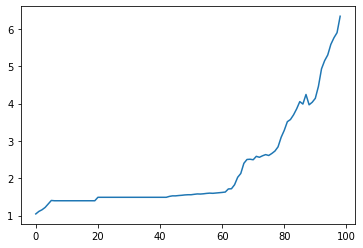

0.18623489751271566


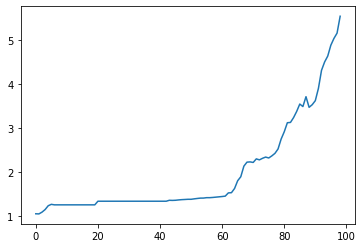

0.18614492298158247


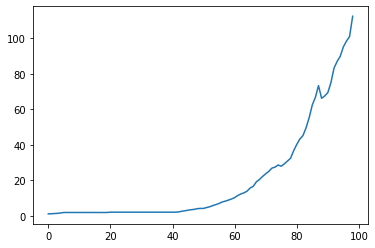

0.18607489801054375


In [ ]:
for index, f in enumerate(figs):
  plt.figure()
  plt.plot(f)
  plt.show()
  print(np_nanmeans[index])


Big Output: Same output as above, but with different risk aversion values

In [ ]:
# Shane

from pypfopt import risk_models as rm
import yfinance as yf
import numpy as np
from cvxpy import Variable, Parameter, Maximize, Problem, sum_squares, norm, quad_form, abs, vstack
import cvxpy as cp
from sklearn.linear_model import LinearRegression
import os

#cov_matrix_methods = ["sample_cov",
#        "semicovariance",
#        "exp_cov",
#        "ledoit_wolf",
#        "ledoit_wolf_constant_variance",
#        "ledoit_wolf_single_factor",
#        "ledoit_wolf_constant_correlation",
#        "oracle_approximating" ]

#sample_cov, exp_cov, ledoit_wolf_constant_correlation don't work

#semicovariance, ledoit_wolf_single_factor give wonky results, leaving out for now

cov_matrix_methods = [
        #"ledoit_wolf",
        "ledoit_wolf_constant_variance",
        "oracle_approximating" ]

figs = []

np_nanmeans = []

portfolios = [] #for evaluations

risks = [100]
for risk in risks:
  print("Running risk: " + str(risk))
  for method in cov_matrix_methods:
    print("Running method: " + method)
    try:

      riskAverse = risk

      #defining some tickers
      tickers = list(set(b.index.get_level_values(1).to_list()))

      #importing ticker's stock data
      # data = yf.download(tickers, period="max")
      data = pd.read_csv("/content/drive/MyDrive/CSE543/daily_price_.csv")
      # prices = data["Adj Close"].dropna(how="all")
      prices = data.set_index("Date").dropna(how="all")
      prices = prices.T.reindex(tickers).T
      dailyReturn = prices / prices.shift(-1) -1


      timeInterval = 8          # years
      riskTimeInterval = 120    # days
      date_range = pd.date_range("2014-01-01", "2022-03-31", freq="BM")
      dateList = [str(d.date()) for d in date_range]

      portfolio = None    # initial portfolio
      wval = None
      for date in tqdm(dateList):
        
        trainStartDate = getDate(date, timeInterval*365)   # 8 years ago
        trainEndDate = getDate(date, 1)                    # last month
        trainData = b.loc[trainStartDate : trainEndDate]
        trainX = trainData.iloc[:, :-1]
        
        trainy = trainData["return"]

        trainy = trainy.rank()
        trainy = (trainy - trainy.mean()) / trainy.std()

        riskStartDate = getDate(date, riskTimeInterval)    # 120 days ago
        riskEndDate = getDate(date, 1)                     # yesterday
        riskDailyReturn = dailyReturn.loc[riskStartDate: riskEndDate]

        testX = b.loc[date].iloc[:, :-1]
        testX = testX.loc[riskDailyReturn.columns.to_list()]
        testX = testX[~testX.index.duplicated(keep='first')]

        testy = b.loc[date]["return"]
        testy = testy.loc[riskDailyReturn.columns.to_list()]
        testy = testy[~testy.index.duplicated(keep='first')]
        #%% Tillman can try some more awesome methods here! return y_hat!
        LR = LinearRegression()
        LR.fit(np.real(trainX), trainy)
        y_hat = LR.predict(np.real(testX))
        corrList.append(np.corrcoef(y_hat, testy)[0,1])
        #%%
        

        #%% Tillman and Shane can try some more awesome methods here! return cov matrix!
        lw_cov = rm.risk_matrix(riskDailyReturn, returns_data = True, method = method)
        cov = eig_decomp(lw_cov, 10 )
        #%%

        numberOfStocks = cov.shape[0]


        # optimization
        w = Variable(numberOfStocks)
        portfolioExpectedReturn = y_hat @ w
        portfolioRisk = quad_form(w, cov) * 240

        objectFunction = portfolioExpectedReturn - riskAverse * portfolioRisk
        cons = []
        # cons.append(cp.sum(w) <= 1 + 1e-6)
        # cons.append(cp.sum(w) >= 1 - 1e-6)    # sum of weights equal to 1
        cons.append(w <= 1)
        cons.append(w >= -1)

        prob = Problem(Maximize(objectFunction), constraints=cons)
        # argskw = {'max_iters': 5000, 'feastol': 1e-5, 'abstol': 1e-5}
        # prob.solve(solver='ECOS')
        try:

          prob.solve()
        
          if prob.status in ('optimal', 'optimal_inaccurate'):
              wval = np.array(w.value)  
          else:
              print("date="+date + '  optimize failed')
              wval = wval
              pass
        except:
          print("date="+date + '  optimize failed')
          if wval is None:
              wval = np.ones(numberOfStocks) / numberOfStocks
          else:
              wval = wval
        # end optimization



        actualPortfolioReturn = wval.dot(testy)
        if portfolio is None:
          portfolio = pd.DataFrame([actualPortfolioReturn])
        else:
          portfolio = portfolio.append([actualPortfolioReturn])

      portfolio = portfolio+1

      #Save portfolio to csv
      portfolio.to_csv('/content/drive/MyDrive/CSE543/big_output/risk'+str(risk)+'_'+method)
      
      #Save nanmean to textfile
      nanmeans_output = '/content/drive/MyDrive/CSE543/big_output/nanmeans.txt'

      file_exists = os.path.exists(nanmeans_output)
      
      if not file_exists:
        with open(nanmeans_output,'w') as f: #Create and overwrite previous
          f.write('risk'+str(risk)+'_'+method+': '+str(np.nanmean(corrList[:-2])))
          f.write('\n')
      else: #Append
        with open(nanmeans_output,'a') as f:
          f.write('risk'+str(risk)+'_'+method+': '+str(np.nanmean(corrList[:-2])))
          f.write('\n')

      #portfolios.append(portfolio)
      #plt.clf()
      #fig = plt.figure()
      #plt.plot(portfolio.cumprod().values)
      figs.append(portfolio.cumprod().values)
      #plt.clf()
      np_nanmeans.append(np.nanmean(corrList[:-2]))
    except:
      print("Failed for method: " +method)

Running risk: 100
Running method: ledoit_wolf_constant_variance


  2%|▏         | 2/99 [01:26<1:19:26, 49.14s/it]

date=2014-02-28  optimize failed


  3%|▎         | 3/99 [02:00<1:07:33, 42.23s/it]

date=2014-03-31  optimize failed


 17%|█▋        | 17/99 [03:33<25:23, 18.57s/it]

date=2015-05-29  optimize failed


 18%|█▊        | 18/99 [05:16<59:08, 43.81s/it]

date=2015-06-30  optimize failed


 19%|█▉        | 19/99 [06:50<1:18:31, 58.89s/it]

date=2015-07-31  optimize failed


 20%|██        | 20/99 [08:25<1:31:58, 69.86s/it]

date=2015-08-31  optimize failed


 28%|██▊       | 28/99 [09:11<17:47, 15.03s/it]

date=2016-04-29  optimize failed


 42%|████▏     | 42/99 [11:38<27:09, 28.59s/it]

date=2017-06-30  optimize failed


 45%|████▌     | 45/99 [12:11<17:35, 19.54s/it]

date=2017-09-29  optimize failed


 46%|████▋     | 46/99 [13:13<28:24, 32.16s/it]

date=2017-10-31  optimize failed


 47%|████▋     | 47/99 [14:15<35:42, 41.21s/it]

date=2017-11-30  optimize failed


 49%|████▉     | 49/99 [14:49<25:18, 30.38s/it]

date=2018-01-31  optimize failed


 51%|█████     | 50/99 [15:55<33:35, 41.13s/it]

date=2018-02-28  optimize failed


 52%|█████▏    | 51/99 [16:59<38:15, 47.82s/it]

date=2018-03-30  optimize failed


 54%|█████▎    | 53/99 [18:04<32:47, 42.77s/it]

date=2018-05-31  optimize failed


 57%|█████▋    | 56/99 [19:10<24:31, 34.22s/it]

date=2018-08-31  optimize failed


 60%|█████▉    | 59/99 [20:14<20:34, 30.85s/it]

date=2018-11-30  optimize failed


 61%|██████    | 60/99 [21:16<26:08, 40.22s/it]

date=2018-12-31  optimize failed


 76%|███████▌  | 75/99 [23:02<09:01, 22.58s/it]

date=2020-03-31  optimize failed


 77%|███████▋  | 76/99 [24:06<13:23, 34.92s/it]

date=2020-04-30  optimize failed


 79%|███████▉  | 78/99 [24:49<10:13, 29.24s/it]

date=2020-06-30  optimize failed


 86%|████████▌ | 85/99 [26:12<05:43, 24.51s/it]

date=2021-01-29  optimize failed


 88%|████████▊ | 87/99 [27:28<06:49, 34.09s/it]

date=2021-03-31  optimize failed


 91%|█████████ | 90/99 [28:13<03:36, 24.11s/it]

date=2021-06-30  optimize failed


100%|██████████| 99/99 [28:34<00:00, 17.32s/it]


Running method: oracle_approximating


 12%|█▏        | 12/99 [01:03<20:33, 14.18s/it]

date=2014-12-31  optimize failed


 73%|███████▎  | 72/99 [03:55<05:18, 11.79s/it]

date=2019-12-31  optimize failed


100%|██████████| 99/99 [04:52<00:00,  2.95s/it]


#Viewing Figures from Big_Output

In [60]:


def std_dev(data):
    #get number of observation
    n = len(data)
    #calculate mean
    mean = sum(data)/n
    #calculate deviations from mean
    deviations = sum([(x-mean)**2 for x in data])
    #calculate variance&standard deviation
    variance = deviations/(n-1)
    s = variance**(1/2)
    return s



def sharpe_ratio(data, risk_rate=0.0):
    # Calculate average daily return
    mean_daily_return = sum(data)/len(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    # Calculate Daily Sharpe Ratio
    monthly_sharpe_ratio = (mean_daily_return - risk_rate)/s
    #Annualize Daily Sharpe Ratio
    sharpe_ratio = 12**(1/2)*monthly_sharpe_ratio
    return sharpe_ratio



37.37730120482339 129.47876947311903
33.13953825782802 114.79872800386146
27.596225895925524 95.59613069778193
23.713771899985453 82.14691553974791
19.133663142444266 66.2809533952429
14.766147444510585 51.15143521189134
   
37.425166671709135 129.64458031426727
33.096135728799325 114.64837723295209
27.909616052911804 96.68174604676638
23.429685815831924 81.1628124767935
19.043030937843664 65.96699422890246
14.476892681491957 50.149427320132226
   
22.477127700971703 77.86305437259364
20.1276566885231 69.7242480436511
17.389552119875017 60.239175584981204
14.651439011400086 50.754073543483344
11.91333580207013 41.26900579362957
9.06972787133705 31.418458967958586


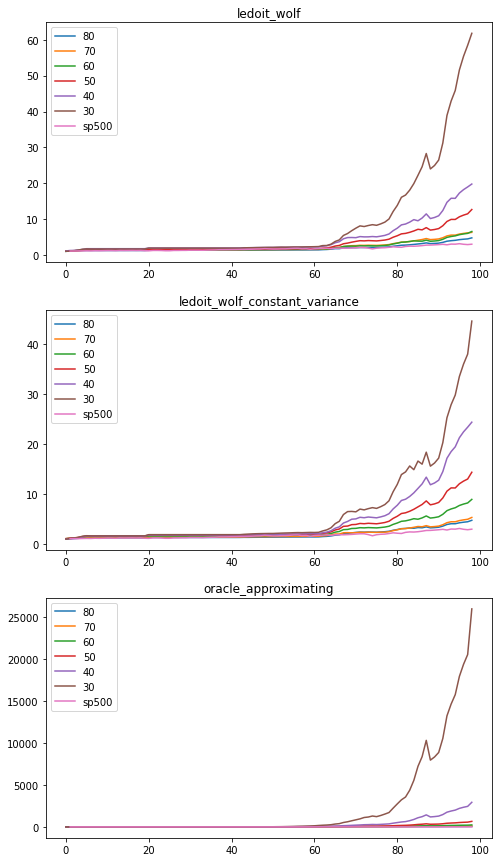

In [64]:
import os
import pandas as pd
from matplotlib import pyplot as plt

import pandas_datareader.data as web
sp500 = web.DataReader('SPY', "av-monthly-adjusted", start = '2014-01-01',end = '2022-03-31',api_key=key)
sp500["adjusted close"]

monthReturn = (sp500["adjusted close"] / sp500["adjusted close"].shift(1))-1



root = '/content/drive/MyDrive/CSE543/big_output/'
methodDict = {"ledoit_wolf": [], "ledoit_wolf_constant_variance": [], "oracle_approximating":[]}
for file in os.listdir('/content/drive/MyDrive/CSE543/big_output/'):
    head, tail = os.path.splitext(file)
    if tail == ".csv":

        risk, method = head.split("_",1)
        if risk in ["risk100", "risk90"]:
            continue
        df = pd.read_csv(os.path.join(root, file))
        df = df.iloc[:,1]
        methodDict[method].append(df)


plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
for df in methodDict["ledoit_wolf"]:
    plt.plot(df.cumprod().values)
    print(df.mean() / df.std(), sharpe_ratio(df))
plt.plot((monthReturn+1).cumprod().values)
plt.title("ledoit_wolf")
plt.legend([80,70,60,50,40,30, "sp500"])

print("   ")
plt.subplot(3,1,2)
for df in methodDict["ledoit_wolf_constant_variance"]:
    plt.plot(df.cumprod().values)
    print(df.mean() / df.std(), sharpe_ratio(df))
plt.plot((monthReturn+1).cumprod().values)
plt.title("ledoit_wolf_constant_variance")
plt.legend([80,70,60,50,40,30, "sp500"])

print("   ")
plt.subplot(3,1,3)
for df in methodDict["oracle_approximating"]:
    plt.plot(df.cumprod().values)
    print(df.mean() / df.std(), sharpe_ratio(df))
plt.plot((monthReturn+1).cumprod().values)
plt.title("oracle_approximating")
plt.legend([80,70,60,50,40,30, "sp500"])
plt.show()

